<a href="https://colab.research.google.com/github/Naomie25/DI-Bootcamp/blob/main/Week6_Day4_ExerciceXP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1 : Data Import and Initial Exploration

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

df = pd.read_csv('/content/household_power_consumption.txt', sep=';',
                 na_values='?',  # remplace les "?" par NaN
                 low_memory=False)  # évite des warnings liés au typage
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
print("\nTypes de données :")
print(df.dtypes)

print("\nDimensions du dataset :")
print(df.shape)



Types de données :
Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

Dimensions du dataset :
(262421, 9)


Part 2 : Handling Missing Values

In [4]:
print("Nombre de valeurs manquantes par colonne :")
print(df.isnull().sum())

Nombre de valeurs manquantes par colonne :
Date                        0
Time                        0
Global_active_power      3772
Global_reactive_power    3772
Voltage                  3773
Global_intensity         3773
Sub_metering_1           3773
Sub_metering_2           3773
Sub_metering_3           3773
dtype: int64


In [5]:
# Convertir les colonnes numériques si ce n’est pas déjà fait
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Remplacer les NaN par la moyenne de chaque colonne
df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.mean()))

In [6]:
print("\nVérification des valeurs manquantes après traitement :")
print(df.isnull().sum())


Vérification des valeurs manquantes après traitement :
Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


Part 3 : Data Visualization

In [7]:
# Fusionner les colonnes Date et Time
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Définir 'Datetime' comme index du DataFrame
df.set_index('Datetime', inplace=True)


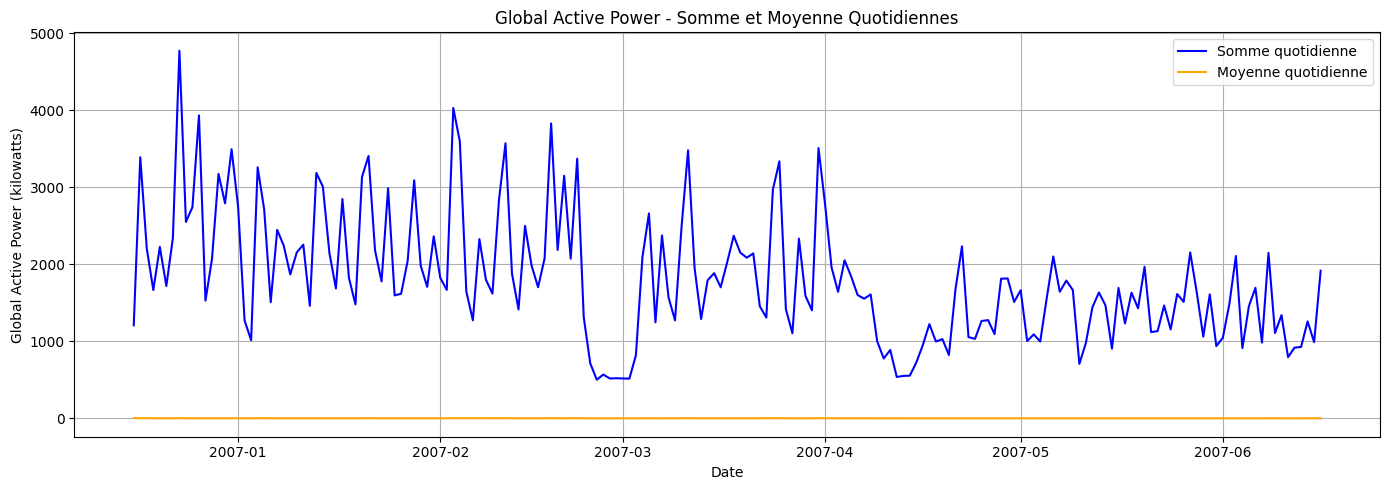

In [8]:
# Conversion en numérique si ce n’est pas déjà fait
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Resample par jour
daily_power_sum = df['Global_active_power'].resample('D').sum()
daily_power_mean = df['Global_active_power'].resample('D').mean()

# Tracer
plt.figure(figsize=(14, 5))
plt.plot(daily_power_sum, label='Somme quotidienne', color='blue')
plt.plot(daily_power_mean, label='Moyenne quotidienne', color='orange')
plt.title("Global Active Power - Somme et Moyenne Quotidiennes")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kilowatts)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


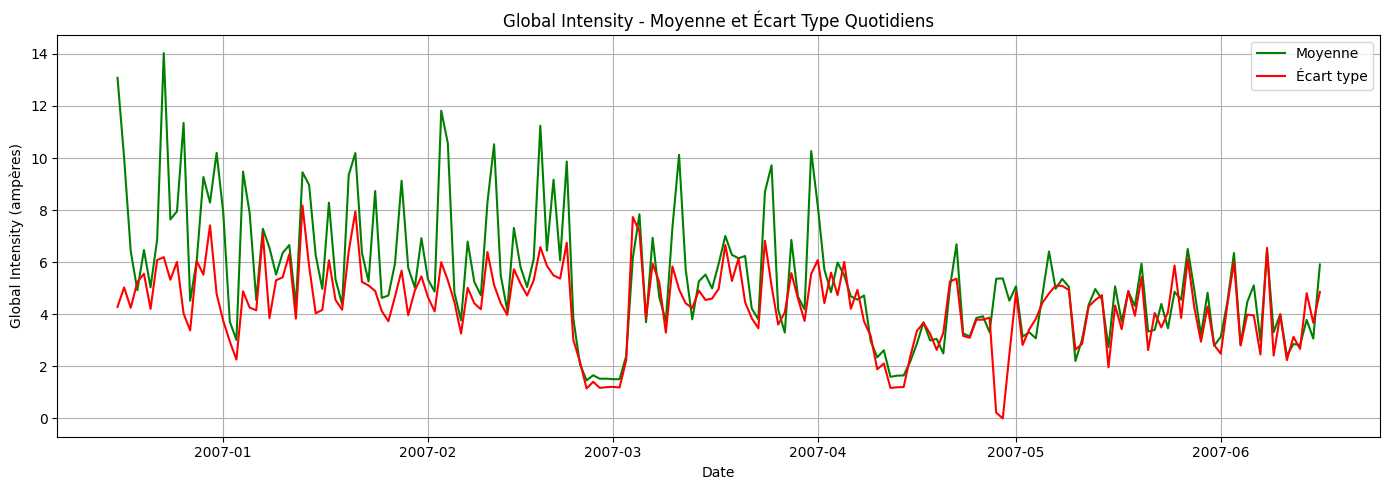

In [9]:
# Conversion en numérique si ce n’est pas déjà fait
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')

# Resample
daily_intensity_mean = df['Global_intensity'].resample('D').mean()
daily_intensity_std = df['Global_intensity'].resample('D').std()

# Tracer
plt.figure(figsize=(14, 5))
plt.plot(daily_intensity_mean, label='Moyenne', color='green')
plt.plot(daily_intensity_std, label='Écart type', color='red')
plt.title("Global Intensity - Moyenne et Écart Type Quotidiens")
plt.xlabel("Date")
plt.ylabel("Global Intensity (ampères)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Part 4 : Data Preprocessing for LSTM

In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# On va prédire 'Global_active_power', donc on garde cette colonne
data = df[['Global_active_power']].dropna()

# Normalisation avec MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data)


In [12]:
# Taille d'entraînement
train_size = int(len(normalized_data) * 0.8)
test_size = len(normalized_data) - train_size

train_data = normalized_data[:train_size]
test_data = normalized_data[train_size:]

In [14]:
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Créer les séquences
time_steps = 10
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Reshape pour LSTM : [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Part 5 : Building an LSTM Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [16]:
# Définir le modèle
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))  # Couche de sortie (une valeur prédite)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer=Adam(), loss='mean_squared_error')

Part 6 : Training and Evaluating the LSTM Model

In [18]:
# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 0.0018 - val_loss: 8.2393e-04
Epoch 2/20
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - loss: 9.9312e-04 - val_loss: 8.0333e-04
Epoch 3/20
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 9.5866e-04 - val_loss: 8.0397e-04
Epoch 4/20
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 9.5168e-04 - val_loss: 7.7697e-04
Epoch 5/20
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - loss: 9.2370e-04 - val_loss: 7.6696e-04
Epoch 6/20
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - loss: 8.8468e-04 - val_loss: 7.7769e-04
Epoch 7/20
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 8.7287e-04 - val_loss: 7.5597e-04
Epoch 8/20
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - loss: 8.4750e-04 - val_loss: 7.4019e-04
Epoch 9/20
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 8.3609e-04 - val_loss: 7.2533e-04
Epoch 10/20
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - loss: 8.1082e-04 - val_loss: 7.5645e-04
Epoch 11/20
6561/6561 ━━━━━━━━━━━

In [19]:
# Évaluation sur le test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")


Test Loss (MSE): 0.0007


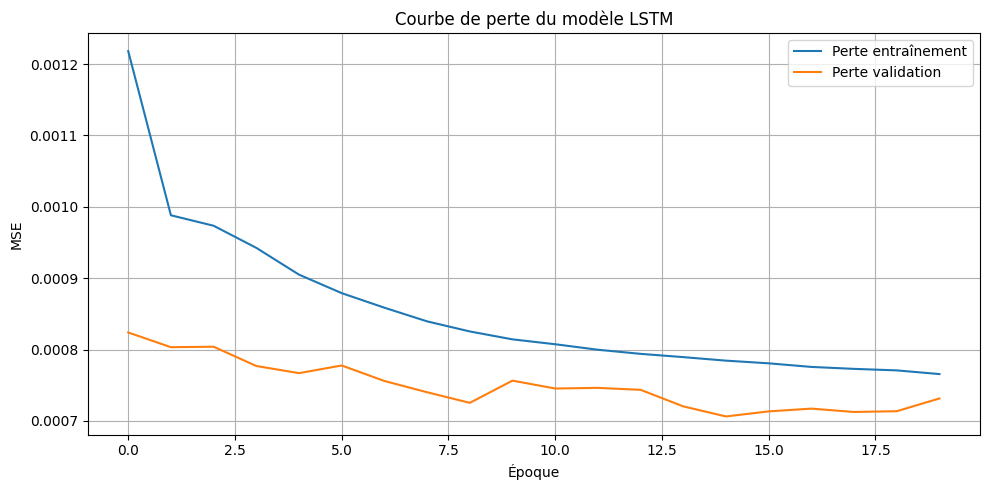

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title("Courbe de perte du modèle LSTM")
plt.xlabel("Époque")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
